In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics ensemble_boxes
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
%env TORCH_USE_CUDA_DSA=1
%env CUDA_LAUNCH_BLOCKING=1
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torchvision.ops import nms
from ultralytics import YOLO
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from ensemble_boxes import weighted_boxes_fusion
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline

env: TORCH_USE_CUDA_DSA=1
env: CUDA_LAUNCH_BLOCKING=1
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
# !pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
device = torch.device("cuda")

In [ ]:
model_yolo = YOLO(dataset_path + "/models/best.pt")

model_frcnn = torch.load(dataset_path + "/models/test(75).pth")
model_frcnn.to(device)
model_frcnn.eval()

model_ssd = torch.load(dataset_path + "/models/ssd.pth")
model_ssd.to(device)
model_ssd.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
def draw_bboxes(image_path, final_boxes, final_labels, final_scores, class_names):
    image = cv2.imread(image_path)

    for box, label, score in zip(final_boxes, final_labels, final_scores):
        x1, y1, x2, y2 = map(int, box)

        color = (0, 255, 0)
        text = f"{class_names[int(label)]}: {score:.2f}"

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

In [ ]:
def run_inference(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Unable to read image at {image_path}. Check if the file exists and is a valid image.")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # YOLO predictions
    yolo_preds = model_yolo(image_path)

    yolo_boxes, yolo_scores, yolo_labels = [], [], []
    for pred in yolo_preds[0].boxes:
        x1, y1, x2, y2 = pred.xyxy[0].tolist()
        score = pred.conf[0].item()
        label = int(pred.cls[0].item())
        yolo_boxes.append([x1 / image.shape[1], y1 / image.shape[0], x2 / image.shape[1], y2 / image.shape[0]])
        yolo_scores.append(score)
        yolo_labels.append(label)

    # Faster R-CNN predictions
    frcnn_preds = model_frcnn([torch.tensor(image_rgb).permute(2, 0, 1).float().to(device) / 255.0])
    frcnn_boxes, frcnn_scores, frcnn_labels = [], [], []
    for box, score, label in zip(frcnn_preds[0]['boxes'], frcnn_preds[0]['scores'], frcnn_preds[0]['labels']):
        if score > 0.3:
            x1, y1, x2, y2 = box.tolist()
            frcnn_boxes.append([x1 / image.shape[1], y1 / image.shape[0], x2 / image.shape[1], y2 / image.shape[0]])
            frcnn_scores.append(score.item())
            frcnn_labels.append(int(label.item()))

    # SSD predictions
    ssd_preds = model_ssd([torch.tensor(image_rgb).permute(2, 0, 1).float().to(device) / 255.0])
    ssd_boxes, ssd_scores, ssd_labels = [], [], []
    for box, score, label in zip(ssd_preds[0]['boxes'], ssd_preds[0]['scores'], ssd_preds[0]['labels']):
        if score > 0.3:
            x1, y1, x2, y2 = box.tolist()
            ssd_boxes.append([x1 / image.shape[1], y1 / image.shape[0], x2 / image.shape[1], y2 / image.shape[0]])
            ssd_scores.append(score.item())
            ssd_labels.append(int(label.item()))

    return yolo_boxes, yolo_scores, yolo_labels, frcnn_boxes, frcnn_scores, frcnn_labels, ssd_boxes, ssd_scores, ssd_labels

In [ ]:
def ensemble_predictions(image_path):
    yolo_boxes, yolo_scores, yolo_labels, frcnn_boxes, frcnn_scores, frcnn_labels, ssd_boxes, ssd_scores, ssd_labels = run_inference(image_path)

    all_boxes = [yolo_boxes, frcnn_boxes, ssd_boxes]
    all_scores = [yolo_scores, frcnn_scores, ssd_scores]
    all_labels = [yolo_labels, frcnn_labels, ssd_labels]

    # Weighted Box Fusion
    final_boxes, final_scores, final_labels = weighted_boxes_fusion(
        all_boxes, all_scores, all_labels, weights=[1, 1, 1], iou_thr=0.5, skip_box_thr=0.3
    )

    # Scale back the box coordinates
    image = cv2.imread(image_path)
    final_boxes = np.array(final_boxes) * [image.shape[1], image.shape[0], image.shape[1], image.shape[0]]

    return final_boxes, final_scores, final_labels


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0168.png: 512x640 39 planes, 82.5ms
Speed: 11.9ms preprocess, 82.5ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


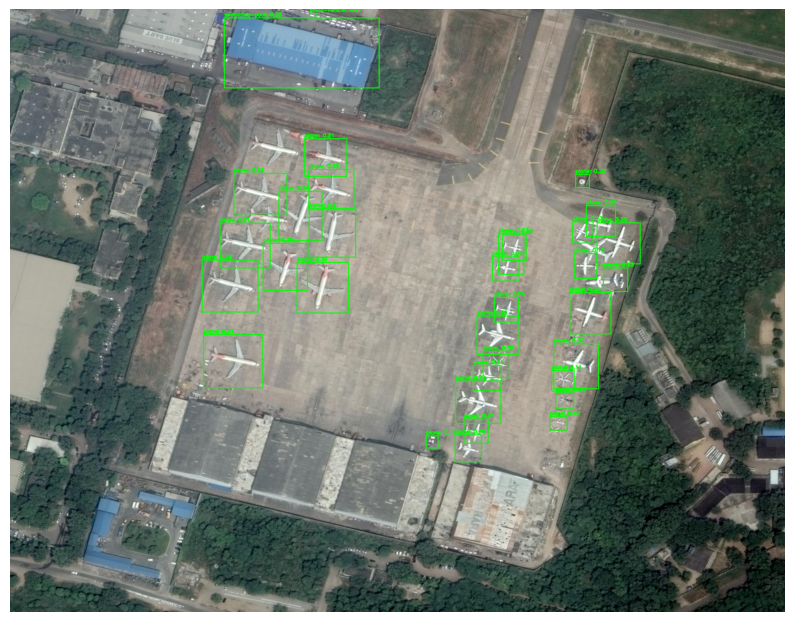

In [ ]:
image_path = "/content/drive/MyDrive/dota_dataset/test/images/P0168.png"
final_boxes, final_scores, final_labels = ensemble_predictions(image_path)

draw_bboxes(image_path, final_boxes, final_labels, final_scores, classes)

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

dataset_path = "/content/drive/MyDrive/dota_dataset/test/"
test_images_dir = dataset_path + "images"
test_labels_dir = dataset_path + "labels"

metric = MeanAveragePrecision(iou_thresholds=[0], class_metrics=True)

def evaluate_ensemble():
    all_preds = []
    all_targets = []

    for image_name in tqdm(os.listdir(test_images_dir)):
        image_path = os.path.join(test_images_dir, image_name)
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        final_boxes, final_scores, final_labels = ensemble_predictions(image_path)

        preds = [{
            "boxes": torch.tensor(final_boxes, dtype=torch.float32),
            "scores": torch.tensor(final_scores, dtype=torch.float32),
            "labels": torch.tensor(final_labels, dtype=torch.int64)
        }]
        all_preds.append(preds[0])

        # Load ground truth labels
        label_path = os.path.join(test_labels_dir, image_name.replace(".png", ".txt"))
        with open(label_path, "r") as f:
            lines = f.readlines()

        gt_boxes = []
        gt_labels = []
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:5])

            x1 = (x_center - width / 2) * img_width
            y1 = (y_center - height / 2) * img_height
            x2 = (x_center + width / 2) * img_width
            y2 = (y_center + height / 2) * img_height

            gt_boxes.append([x1, y1, x2, y2])
            gt_labels.append(label)

        # Convert ground truth to required format
        targets = [{
            "boxes": torch.tensor(gt_boxes, dtype=torch.float32),
            "labels": torch.tensor(gt_labels, dtype=torch.int64)
        }]
        all_targets.append(targets[0])

    # Compute mAP
    metric.update(all_preds, all_targets)
    results = metric.compute()
    print(results)

evaluate_ensemble()

  0%|          | 0/458 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0004.png: 640x384 13 small-vehicles, 68 large-vehicles, 128.1ms
Speed: 3.6ms preprocess, 128.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


  0%|          | 1/458 [00:02<18:53,  2.48s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0003.png: 576x640 9 small-vehicles, 48 large-vehicles, 175.0ms
Speed: 32.7ms preprocess, 175.0ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 640)


  0%|          | 2/458 [00:04<15:21,  2.02s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0007.png: 640x448 17 small-vehicles, 118 large-vehicles, 87.0ms
Speed: 4.1ms preprocess, 87.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 448)


  1%|          | 3/458 [00:06<16:59,  2.24s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0047.png: 640x352 6 baseball-diamonds, 1 ground-track-field, 27 small-vehicles, 2 soccer-ball-fields, 54.2ms
Speed: 3.1ms preprocess, 54.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


  1%|          | 4/458 [00:08<15:05,  1.99s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0053.png: 640x640 8 small-vehicles, 69 large-vehicles, 86.2ms
Speed: 45.7ms preprocess, 86.2ms inference, 19.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 5/458 [01:48<4:42:12, 37.38s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0060.png: 416x640 24 swimming-pools, 53.2ms
Speed: 2.8ms preprocess, 53.2ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


  1%|▏         | 6/458 [01:50<3:10:05, 25.23s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0056.png: 608x640 11 small-vehicles, 18 large-vehicles, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 14.2ms postprocess per image at shape (1, 3, 608, 640)


  2%|▏         | 7/458 [01:50<2:09:37, 17.25s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0019.png: 384x640 51 harbors, 51.6ms
Speed: 3.2ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 8/458 [01:54<1:36:16, 12.84s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0027.png: 512x640 37 harbors, 1 swimming-pool, 54.2ms
Speed: 3.1ms preprocess, 54.2ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)


  2%|▏         | 9/458 [01:55<1:08:36,  9.17s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0075.png: 640x352 1 roundabout, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 352)


  2%|▏         | 10/458 [01:55<48:41,  6.52s/it] 


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0086.png: 640x512 173 small-vehicles, 2 roundabouts, 64.8ms
Speed: 3.0ms preprocess, 64.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


  2%|▏         | 11/458 [01:56<35:41,  4.79s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0130.png: 640x544 6 baseball-diamonds, 1 ground-track-field, 3 tennis-courts, 1 soccer-ball-field, 7 swimming-pools, 49.7ms
Speed: 4.0ms preprocess, 49.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 12/458 [01:57<26:28,  3.56s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0143.png: 480x640 2 ground-track-fields, 3 soccer-ball-fields, 48.1ms
Speed: 2.4ms preprocess, 48.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  3%|▎         | 13/458 [01:58<20:00,  2.70s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0104.png: 640x512 39 small-vehicles, 2 roundabouts, 18.8ms
Speed: 4.4ms preprocess, 18.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 14/458 [01:59<15:34,  2.11s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0081.png: 640x512 1 roundabout, 20.8ms
Speed: 5.4ms preprocess, 20.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


  3%|▎         | 15/458 [01:59<12:11,  1.65s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0131.png: 544x640 3 baseball-diamonds, 1 ground-track-field, 32 small-vehicles, 6 tennis-courts, 2 basketball-courts, 1 soccer-ball-field, 4 swimming-pools, 70.1ms
Speed: 4.7ms preprocess, 70.1ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


  3%|▎         | 16/458 [02:00<10:37,  1.44s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0117.png: 544x640 5 baseball-diamonds, 4 small-vehicles, 2 soccer-ball-fields, 14.4ms
Speed: 3.1ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


  4%|▎         | 17/458 [02:01<08:50,  1.20s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0079.png: 576x640 2 small-vehicles, 1 roundabout, 1 swimming-pool, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


  4%|▍         | 18/458 [02:01<07:39,  1.04s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0128.png: 640x544 25 small-vehicles, 132 ships, 8 harbors, 18.2ms
Speed: 3.3ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


  4%|▍         | 19/458 [02:02<07:13,  1.01it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0146.png: 448x640 5 baseball-diamonds, 20 small-vehicles, 3 tennis-courts, 1 soccer-ball-field, 49.8ms
Speed: 2.9ms preprocess, 49.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


  4%|▍         | 20/458 [02:03<07:26,  1.02s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0110.png: 544x640 (no detections), 15.6ms
Speed: 3.2ms preprocess, 15.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


  5%|▍         | 21/458 [02:04<07:25,  1.02s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0150.png: 544x640 1 baseball-diamond, 52 small-vehicles, 1 tennis-court, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 6.4ms postprocess per image at shape (1, 3, 544, 640)


  5%|▍         | 22/458 [02:05<06:37,  1.10it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0123.png: 640x544 88 small-vehicles, 12 tennis-courts, 15.3ms
Speed: 2.9ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


  5%|▌         | 23/458 [02:06<06:09,  1.18it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0173.png: 544x640 10 planes, 3 small-vehicles, 3 large-vehicles, 15.7ms
Speed: 2.8ms preprocess, 15.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)


  5%|▌         | 24/458 [02:06<05:46,  1.25it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0168.png: 512x640 39 planes, 14.4ms
Speed: 3.1ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  5%|▌         | 25/458 [02:07<06:07,  1.18it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0170.png: 352x640 28 planes, 32 small-vehicles, 1 large-vehicle, 49.2ms
Speed: 2.2ms preprocess, 49.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


  6%|▌         | 26/458 [02:08<05:50,  1.23it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0161.png: 640x640 18 planes, 4 small-vehicles, 15.4ms
Speed: 3.8ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 27/458 [02:09<06:46,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0175.png: 640x576 2 small-vehicles, 11 tennis-courts, 53.1ms
Speed: 3.0ms preprocess, 53.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 576)


  6%|▌         | 28/458 [02:10<06:12,  1.16it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0179.png: 640x640 101 planes, 21 small-vehicles, 1 soccer-ball-field, 25.5ms
Speed: 6.0ms preprocess, 25.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 29/458 [02:14<11:50,  1.66s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0217.png: 608x640 35 planes, 10 small-vehicles, 18.1ms
Speed: 3.5ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)


  7%|▋         | 30/458 [02:14<09:54,  1.39s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0194.png: 544x640 8 small-vehicles, 8 tennis-courts, 1 swimming-pool, 15.3ms
Speed: 2.8ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  7%|▋         | 31/458 [02:15<08:19,  1.17s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0249.png: 640x416 30 planes, 8 small-vehicles, 6 large-vehicles, 50.2ms
Speed: 2.4ms preprocess, 50.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)


  7%|▋         | 32/458 [02:16<07:44,  1.09s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0213.png: 576x640 51 planes, 22 small-vehicles, 15.2ms
Speed: 3.4ms preprocess, 15.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


  7%|▋         | 33/458 [02:17<07:45,  1.10s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0189.png: 640x512 18 small-vehicles, 35 large-vehicles, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


  7%|▋         | 34/458 [02:18<06:41,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0228.png: 416x640 1 baseball-diamond, 12 tennis-courts, 14.6ms
Speed: 2.5ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


  8%|▊         | 35/458 [02:18<06:12,  1.14it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0199.png: 640x480 2 baseball-diamonds, 51 small-vehicles, 26 tennis-courts, 49.4ms
Speed: 2.8ms preprocess, 49.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


  8%|▊         | 36/458 [02:19<05:54,  1.19it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0237.png: 640x640 9 small-vehicles, 8 tennis-courts, 16.0ms
Speed: 3.1ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 37/458 [02:20<05:26,  1.29it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0206.png: 640x576 1 baseball-diamond, 10 tennis-courts, 15.7ms
Speed: 3.4ms preprocess, 15.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


  8%|▊         | 38/458 [02:20<05:18,  1.32it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0198.png: 640x576 23 tennis-courts, 16.5ms
Speed: 3.2ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


  9%|▊         | 39/458 [02:21<05:22,  1.30it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0246.png: 640x512 7 small-vehicles, 27 large-vehicles, 14.5ms
Speed: 2.5ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


  9%|▊         | 40/458 [02:22<05:08,  1.36it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0242.png: 640x288 8 tennis-courts, 1 basketball-court, 1 soccer-ball-field, 49.0ms
Speed: 1.8ms preprocess, 49.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


  9%|▉         | 41/458 [02:23<04:59,  1.39it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0186.png: 288x640 10 tennis-courts, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


  9%|▉         | 42/458 [02:23<04:47,  1.45it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0305.png: 640x512 31 small-vehicles, 6 large-vehicles, 20.4ms
Speed: 3.7ms preprocess, 20.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 512)


  9%|▉         | 43/458 [02:24<04:49,  1.43it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0261.png: 512x640 229 small-vehicles, 10 large-vehicles, 21.1ms
Speed: 4.0ms preprocess, 21.1ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


 10%|▉         | 44/458 [02:25<05:14,  1.32it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0329.png: 640x512 14 small-vehicles, 10 large-vehicles, 19.1ms
Speed: 3.9ms preprocess, 19.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 10%|▉         | 45/458 [02:25<04:54,  1.40it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0300.png: 384x640 3 small-vehicles, 7 harbors, 24.8ms
Speed: 3.7ms preprocess, 24.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 46/458 [02:26<04:51,  1.42it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0309.png: 640x288 8 harbors, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


 10%|█         | 47/458 [02:27<04:50,  1.41it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0262.png: 640x608 284 ships, 16 harbors, 48.3ms
Speed: 3.6ms preprocess, 48.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


 10%|█         | 48/458 [02:28<05:46,  1.18it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0259.png: 640x640 3 small-vehicles, 1 ship, 14 harbors, 17.3ms
Speed: 3.6ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 49/458 [02:29<06:27,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0257.png: 640x448 37 planes, 113 small-vehicles, 15.7ms
Speed: 2.8ms preprocess, 15.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 11%|█         | 50/458 [02:30<06:14,  1.09it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0331.png: 576x640 3 small-vehicles, 10 ships, 13 harbors, 6 swimming-pools, 22.9ms
Speed: 3.4ms preprocess, 22.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)


 11%|█         | 51/458 [02:31<06:42,  1.01it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0336.png: 320x640 2 ships, 10 harbors, 52.4ms
Speed: 2.1ms preprocess, 52.4ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)


 11%|█▏        | 52/458 [02:32<06:48,  1.01s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0375.png: 640x640 1 baseball-diamond, 64 small-vehicles, 5 tennis-courts, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 53/458 [02:33<05:59,  1.13it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0411.png: 640x512 3 ships, 10 harbors, 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 12%|█▏        | 54/458 [02:34<05:54,  1.14it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0352.png: 608x640 3 baseball-diamonds, 16 small-vehicles, 5 tennis-courts, 2 basketball-courts, 14.9ms
Speed: 3.4ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 12%|█▏        | 55/458 [02:34<05:27,  1.23it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0347.png: 640x320 1 small-vehicle, 1 ship, 9 harbors, 47.1ms
Speed: 3.1ms preprocess, 47.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


 12%|█▏        | 56/458 [02:35<06:10,  1.08it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0342.png: 640x640 9 small-vehicles, 27 large-vehicles, 15.7ms
Speed: 3.2ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 57/458 [02:36<05:34,  1.20it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0348.png: 640x288 1 ship, 8 harbors, 17.5ms
Speed: 2.8ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


 13%|█▎        | 58/458 [02:37<05:25,  1.23it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0359.png: 640x480 7 tennis-courts, 17.6ms
Speed: 3.7ms preprocess, 17.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 59/458 [02:38<05:23,  1.23it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0402.png: 640x480 5 tennis-courts, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


 13%|█▎        | 60/458 [02:38<05:16,  1.26it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0396.png: 640x608 7 tennis-courts, 17.8ms
Speed: 3.5ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 13%|█▎        | 61/458 [02:39<05:08,  1.28it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0368.png: 640x384 21 small-vehicles, 4 tennis-courts, 2 basketball-courts, 1 soccer-ball-field, 16.7ms
Speed: 2.4ms preprocess, 16.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 14%|█▎        | 62/458 [02:40<04:55,  1.34it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0385.png: 640x640 4 small-vehicles, 3 tennis-courts, 5 basketball-courts, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 63/458 [02:40<04:40,  1.41it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0382.png: 640x608 2 baseball-diamonds, 12 small-vehicles, 4 tennis-courts, 15.6ms
Speed: 3.3ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 14%|█▍        | 64/458 [02:41<04:37,  1.42it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0377.png: 640x640 1 small-vehicle, 5 tennis-courts, 15.8ms
Speed: 3.4ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 65/458 [02:42<04:24,  1.49it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0374.png: 576x640 2 baseball-diamonds, 39 small-vehicles, 8 basketball-courts, 16.6ms
Speed: 3.3ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 14%|█▍        | 66/458 [02:43<04:31,  1.44it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0353.png: 640x640 72 small-vehicles, 22 large-vehicles, 15.2ms
Speed: 3.5ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 67/458 [02:43<04:33,  1.43it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0414.png: 640x512 9 small-vehicles, 5 ships, 8 harbors, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 15%|█▍        | 68/458 [02:44<04:12,  1.55it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0491.png: 416x640 7 baseball-diamonds, 1 basketball-court, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 15%|█▌        | 69/458 [02:45<05:02,  1.29it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0524.png: 640x640 1 small-vehicle, 3 ships, 10 harbors, 17.6ms
Speed: 5.3ms preprocess, 17.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 70/458 [02:45<04:37,  1.40it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0518.png: 640x512 2 ships, 10 harbors, 14.5ms
Speed: 2.9ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 16%|█▌        | 71/458 [02:46<04:31,  1.42it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0486.png: 448x640 27 small-vehicles, 33 large-vehicles, 14.0ms
Speed: 2.6ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▌        | 72/458 [02:47<04:44,  1.36it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0525.png: 640x288 1 ship, 8 harbors, 19.2ms
Speed: 5.4ms preprocess, 19.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


 16%|█▌        | 73/458 [02:48<04:39,  1.38it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0526.png: 480x640 2 ships, 7 harbors, 14.6ms
Speed: 2.9ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 16%|█▌        | 74/458 [02:49<05:26,  1.18it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0420.png: 448x640 3 ships, 12 harbors, 2 swimming-pools, 24.0ms
Speed: 5.8ms preprocess, 24.0ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


 16%|█▋        | 75/458 [02:50<05:21,  1.19it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0454.png: 448x640 38 small-vehicles, 74 large-vehicles, 16.1ms
Speed: 4.1ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 17%|█▋        | 76/458 [02:51<05:51,  1.09it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0476.png: 640x608 7 small-vehicles, 69 large-vehicles, 15.6ms
Speed: 3.4ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 17%|█▋        | 77/458 [02:51<05:30,  1.15it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0499.png: 640x576 11 small-vehicles, 6 tennis-courts, 15.1ms
Speed: 3.3ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


 17%|█▋        | 78/458 [02:52<04:56,  1.28it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0457.png: 416x640 1 baseball-diamond, 6 small-vehicles, 2 tennis-courts, 2 basketball-courts, 14.8ms
Speed: 2.5ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 17%|█▋        | 79/458 [02:53<04:47,  1.32it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0466.png: 640x608 1 small-vehicle, 14 tennis-courts, 1 soccer-ball-field, 15.4ms
Speed: 3.4ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 17%|█▋        | 80/458 [02:53<04:43,  1.33it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0432.png: 608x640 2 ships, 11 harbors, 15.0ms
Speed: 2.9ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


 18%|█▊        | 81/458 [02:54<04:28,  1.40it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0543.png: 480x640 1 ship, 4 harbors, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 18%|█▊        | 82/458 [02:55<04:27,  1.40it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0557.png: 352x640 3 ships, 8 harbors, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


 18%|█▊        | 83/458 [02:55<04:26,  1.41it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0579.png: 352x640 8 harbors, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 18%|█▊        | 84/458 [02:56<04:29,  1.39it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0564.png: 640x512 1 ship, 4 harbors, 14.3ms
Speed: 2.8ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▊        | 85/458 [02:57<04:19,  1.44it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0577.png: 640x416 1 small-vehicle, 9 harbors, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 19%|█▉        | 86/458 [02:58<04:24,  1.41it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0590.png: 576x640 56 small-vehicles, 105 large-vehicles, 15.4ms
Speed: 3.2ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 19%|█▉        | 87/458 [02:58<04:36,  1.34it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0547.png: 640x512 3 small-vehicles, 46 large-vehicles, 14.8ms
Speed: 2.8ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 19%|█▉        | 88/458 [02:59<04:30,  1.37it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0583.png: 192x640 1 ship, 8 harbors, 52.6ms
Speed: 1.3ms preprocess, 52.6ms inference, 2.2ms postprocess per image at shape (1, 3, 192, 640)


 19%|█▉        | 89/458 [03:00<04:32,  1.35it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0550.png: 384x640 2 ships, 15 harbors, 16.4ms
Speed: 2.4ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 90/458 [03:01<04:26,  1.38it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0589.png: 640x256 7 harbors, 70.4ms
Speed: 4.5ms preprocess, 70.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


 20%|█▉        | 91/458 [03:01<04:37,  1.32it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0559.png: 640x640 21 small-vehicles, 24 large-vehicles, 27.8ms
Speed: 5.0ms preprocess, 27.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 92/458 [03:02<04:25,  1.38it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0551.png: 640x640 2 ships, 5 harbors, 19.5ms
Speed: 5.4ms preprocess, 19.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 93/458 [03:03<04:44,  1.29it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0558.png: 640x256 9 harbors, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


 21%|██        | 94/458 [03:04<04:26,  1.36it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0665.png: 640x512 1 baseball-diamond, 44 small-vehicles, 6 tennis-courts, 2 soccer-ball-fields, 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 21%|██        | 95/458 [03:05<04:48,  1.26it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0654.png: 640x608 3 small-vehicles, 19 large-vehicles, 15.8ms
Speed: 3.5ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 21%|██        | 96/458 [03:05<04:36,  1.31it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0650.png: 416x640 2 small-vehicles, 7 tennis-courts, 14.6ms
Speed: 2.3ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 21%|██        | 97/458 [03:06<04:14,  1.42it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0647.png: 640x512 4 small-vehicles, 4 tennis-courts, 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 21%|██▏       | 98/458 [03:06<03:54,  1.54it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0613.png: 480x640 1 small-vehicle, 6 harbors, 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 22%|██▏       | 99/458 [03:07<03:58,  1.50it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0659.png: 640x384 4 tennis-courts, 2 basketball-courts, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


 22%|██▏       | 100/458 [03:08<03:57,  1.51it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0660.png: 512x640 15 small-vehicles, 4 tennis-courts, 1 storage-tank, 1 swimming-pool, 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 22%|██▏       | 101/458 [03:08<03:56,  1.51it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0604.png: 416x640 14 small-vehicles, 4 ships, 13 harbors, 1 swimming-pool, 17.0ms
Speed: 2.5ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 22%|██▏       | 102/458 [03:09<04:05,  1.45it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0651.png: 640x512 15 tennis-courts, 19.9ms
Speed: 4.0ms preprocess, 19.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


 22%|██▏       | 103/458 [03:10<03:54,  1.52it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0615.png: 640x640 2 ships, 8 harbors, 15.9ms
Speed: 3.5ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 104/458 [03:10<04:01,  1.46it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0623.png: 640x640 61 small-vehicles, 24 large-vehicles, 14.9ms
Speed: 3.5ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 105/458 [03:11<04:11,  1.40it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0643.png: 640x512 15 small-vehicles, 16 large-vehicles, 15.0ms
Speed: 2.5ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 23%|██▎       | 106/458 [03:13<06:39,  1.14s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0622.png: 640x416 1 small-vehicle, 5 ships, 8 harbors, 22.0ms
Speed: 4.3ms preprocess, 22.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


 23%|██▎       | 107/458 [03:14<06:11,  1.06s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0673.png: 640x640 1 baseball-diamond, 4 tennis-courts, 4 basketball-courts, 1 soccer-ball-field, 20.5ms
Speed: 5.3ms preprocess, 20.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 108/458 [03:15<05:39,  1.03it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0706.png: 640x608 290 ships, 10 harbors, 25.2ms
Speed: 5.0ms preprocess, 25.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 608)


 24%|██▍       | 109/458 [03:16<05:29,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0704.png: 448x640 2 small-vehicles, 278 ships, 20 harbors, 16.0ms
Speed: 2.7ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 24%|██▍       | 110/458 [03:17<05:23,  1.07it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0696.png: 640x480 1 small-vehicle, 274 ships, 25 harbors, 14.5ms
Speed: 2.9ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 24%|██▍       | 111/458 [03:18<05:16,  1.10it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0683.png: 640x544 25 small-vehicles, 3 ships, 5 harbors, 15.0ms
Speed: 3.2ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 24%|██▍       | 112/458 [03:19<05:25,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0761.png: 544x640 36 small-vehicles, 71 ships, 28 harbors, 14.8ms
Speed: 3.1ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 25%|██▍       | 113/458 [03:19<05:07,  1.12it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0684.png: 640x480 3 small-vehicles, 12 large-vehicles, 18.8ms
Speed: 3.7ms preprocess, 18.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


 25%|██▍       | 114/458 [03:20<04:52,  1.18it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0763.png: 448x640 31 small-vehicles, 42 ships, 57 harbors, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 25%|██▌       | 115/458 [03:21<04:41,  1.22it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0715.png: 640x544 5 small-vehicles, 13 ships, 28 harbors, 15.3ms
Speed: 3.1ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 116/458 [03:22<04:42,  1.21it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0712.png: 640x512 13 small-vehicles, 49 large-vehicles, 16.2ms
Speed: 2.8ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 26%|██▌       | 117/458 [03:22<04:27,  1.28it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0725.png: 448x640 22 small-vehicles, 26 ships, 29 harbors, 19.1ms
Speed: 2.6ms preprocess, 19.1ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▌       | 118/458 [03:23<04:34,  1.24it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0729.png: 640x320 14 small-vehicles, 20 ships, 18 harbors, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 26%|██▌       | 119/458 [03:24<04:24,  1.28it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0749.png: 384x640 21 small-vehicles, 36 ships, 18 harbors, 15.3ms
Speed: 2.4ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 120/458 [03:25<04:22,  1.29it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0764.png: 448x640 29 small-vehicles, 40 ships, 60 harbors, 1 swimming-pool, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 26%|██▋       | 121/458 [03:26<04:34,  1.23it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0770.png: 544x640 3 baseball-diamonds, 1 ground-track-field, 32 small-vehicles, 9 tennis-courts, 2 soccer-ball-fields, 4 swimming-pools, 17.8ms
Speed: 5.6ms preprocess, 17.8ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 27%|██▋       | 122/458 [03:27<04:39,  1.20it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0815.png: 480x640 1 baseball-diamond, 6 tennis-courts, 17.7ms
Speed: 4.1ms preprocess, 17.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 27%|██▋       | 123/458 [03:27<04:21,  1.28it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0795.png: 640x480 1 small-vehicle, 287 ships, 12 harbors, 25.6ms
Speed: 4.3ms preprocess, 25.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


 27%|██▋       | 124/458 [03:28<04:57,  1.12it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0799.png: 640x480 4 small-vehicles, 281 ships, 2 tennis-courts, 13 harbors, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


 27%|██▋       | 125/458 [03:29<04:48,  1.15it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0796.png: 640x192 1 small-vehicle, 186 ships, 1 storage-tank, 25 harbors, 46.5ms
Speed: 1.5ms preprocess, 46.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


 28%|██▊       | 126/458 [03:30<04:38,  1.19it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0787.png: 640x640 30 small-vehicles, 49 large-vehicles, 15.1ms
Speed: 3.5ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 127/458 [03:31<04:17,  1.29it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0814.png: 256x640 20 small-vehicles, 7 tennis-courts, 50.2ms
Speed: 1.7ms preprocess, 50.2ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


 28%|██▊       | 128/458 [03:31<04:13,  1.30it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0801.png: 320x640 290 ships, 10 harbors, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)


 28%|██▊       | 129/458 [03:33<05:15,  1.04it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0789.png: 448x640 15 small-vehicles, 270 ships, 15 harbors, 15.2ms
Speed: 2.8ms preprocess, 15.2ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|██▊       | 130/458 [03:33<04:53,  1.12it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0791.png: 640x640 4 baseball-diamonds, 87 small-vehicles, 7 tennis-courts, 16.6ms
Speed: 3.7ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 131/458 [03:34<04:40,  1.17it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0822.png: 320x640 6 tennis-courts, 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 29%|██▉       | 132/458 [03:35<04:10,  1.30it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0833.png: 480x640 44 small-vehicles, 16 tennis-courts, 15 basketball-courts, 14.7ms
Speed: 2.8ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 29%|██▉       | 133/458 [03:36<04:07,  1.31it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0839.png: 640x224 295 ships, 5 harbors, 46.7ms
Speed: 1.6ms preprocess, 46.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


 29%|██▉       | 134/458 [03:36<04:04,  1.33it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0816.png: 480x640 32 small-vehicles, 6 tennis-courts, 16.1ms
Speed: 2.8ms preprocess, 16.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


 29%|██▉       | 135/458 [03:37<04:00,  1.34it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0838.png: 640x512 291 ships, 9 harbors, 14.3ms
Speed: 3.1ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 30%|██▉       | 136/458 [03:38<03:55,  1.37it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0844.png: 640x512 8 tennis-courts, 24.1ms
Speed: 3.7ms preprocess, 24.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


 30%|██▉       | 137/458 [03:38<03:56,  1.36it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0841.png: 640x512 25 planes, 11 small-vehicles, 19.1ms
Speed: 4.6ms preprocess, 19.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


 30%|███       | 138/458 [03:40<05:26,  1.02s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0858.png: 416x640 282 ships, 18 harbors, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 6.5ms postprocess per image at shape (1, 3, 416, 640)


 30%|███       | 139/458 [03:41<05:32,  1.04s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0837.png: 640x416 290 ships, 10 harbors, 16.1ms
Speed: 2.6ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


 31%|███       | 140/458 [03:42<05:36,  1.06s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0882.png: 640x288 50 small-vehicles, 15 tennis-courts, 1 swimming-pool, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


 31%|███       | 141/458 [03:43<05:13,  1.01it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0904.png: 608x640 12 small-vehicles, 5 tennis-courts, 1 roundabout, 15.6ms
Speed: 3.1ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 31%|███       | 142/458 [03:44<04:48,  1.10it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0864.png: 448x640 1 small-vehicle, 215 ships, 34 harbors, 14.1ms
Speed: 2.8ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 31%|███       | 143/458 [03:45<05:22,  1.02s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0897.png: 640x320 266 ships, 34 harbors, 15.5ms
Speed: 2.9ms preprocess, 15.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 320)


 31%|███▏      | 144/458 [03:47<06:45,  1.29s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0887.png: 640x512 292 ships, 8 harbors, 14.4ms
Speed: 3.1ms preprocess, 14.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 32%|███▏      | 145/458 [03:48<06:29,  1.25s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0929.png: 640x64 (no detections), 46.5ms
Speed: 0.9ms preprocess, 46.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 64)


 32%|███▏      | 146/458 [03:49<06:05,  1.17s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0932.png: 640x640 14 harbors, 15.0ms
Speed: 3.4ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 147/458 [03:50<05:21,  1.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0949.png: 192x640 26 harbors, 1 swimming-pool, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 192, 640)


 32%|███▏      | 148/458 [03:51<05:06,  1.01it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0961.png: 128x640 2 ships, 31 harbors, 73.0ms
Speed: 1.7ms preprocess, 73.0ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 640)


 33%|███▎      | 149/458 [03:52<05:55,  1.15s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0945.png: 640x640 5 small-vehicles, 21 ships, 2 storage-tanks, 54 harbors, 23.7ms
Speed: 4.7ms preprocess, 23.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 150/458 [03:53<05:38,  1.10s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0953.png: 256x640 11 harbors, 1 swimming-pool, 17.6ms
Speed: 2.3ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 640)


 33%|███▎      | 151/458 [03:54<05:17,  1.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0910.png: 608x640 106 harbors, 20.1ms
Speed: 3.5ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


 33%|███▎      | 152/458 [03:55<05:11,  1.02s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0936.png: 256x640 24 harbors, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 640)


 33%|███▎      | 153/458 [03:56<05:03,  1.00it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0977.png: 640x608 1 small-vehicle, 4 ships, 16 harbors, 15.6ms
Speed: 3.7ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 34%|███▎      | 154/458 [03:57<04:58,  1.02it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0969.png: 576x640 45 small-vehicles, 6 large-vehicles, 15.3ms
Speed: 2.7ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 34%|███▍      | 155/458 [03:58<04:16,  1.18it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0970.png: 192x640 21 harbors, 1 swimming-pool, 14.1ms
Speed: 1.5ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 192, 640)


 34%|███▍      | 156/458 [03:58<04:21,  1.16it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0990.png: 640x640 52 harbors, 4 swimming-pools, 17.5ms
Speed: 3.7ms preprocess, 17.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 157/458 [04:00<04:44,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0962.png: 224x640 15 harbors, 49.1ms
Speed: 1.6ms preprocess, 49.1ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)


 34%|███▍      | 158/458 [04:00<04:31,  1.10it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0989.png: 640x448 18 harbors, 2 swimming-pools, 15.3ms
Speed: 2.7ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 35%|███▍      | 159/458 [04:01<04:20,  1.15it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0974.png: 320x640 11 harbors, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 35%|███▍      | 160/458 [04:02<04:09,  1.19it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0968.png: 256x640 11 harbors, 14.9ms
Speed: 1.7ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)


 35%|███▌      | 161/458 [04:03<03:55,  1.26it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0964.png: 224x640 18 harbors, 14.6ms
Speed: 1.7ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


 35%|███▌      | 162/458 [04:04<04:24,  1.12it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1005.png: 160x640 (no detections), 70.6ms
Speed: 2.0ms preprocess, 70.6ms inference, 0.8ms postprocess per image at shape (1, 3, 160, 640)


 36%|███▌      | 163/458 [04:06<05:40,  1.16s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P0998.png: 160x640 29 harbors, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 160, 640)


 36%|███▌      | 164/458 [04:07<05:57,  1.21s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1007.png: 128x640 24 harbors, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 3.6ms postprocess per image at shape (1, 3, 128, 640)


 36%|███▌      | 165/458 [04:09<06:39,  1.36s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1029.png: 416x640 4 ships, 69 harbors, 18.9ms
Speed: 2.7ms preprocess, 18.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


 36%|███▌      | 166/458 [04:10<06:10,  1.27s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1022.png: 288x640 1 ship, 16 harbors, 17.0ms
Speed: 1.9ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 36%|███▋      | 167/458 [04:11<05:41,  1.17s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1014.png: 608x640 282 harbors, 3 swimming-pools, 15.7ms
Speed: 3.5ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 37%|███▋      | 168/458 [04:12<05:23,  1.12s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1023.png: 192x640 35 harbors, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 192, 640)


 37%|███▋      | 169/458 [04:13<05:03,  1.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1009.png: 224x640 12 ships, 27 harbors, 14.6ms
Speed: 2.0ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)


 37%|███▋      | 170/458 [04:14<05:09,  1.08s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1021.png: 320x640 1 ship, 32 harbors, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 37%|███▋      | 171/458 [04:14<04:41,  1.02it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1065.png: 384x640 38 harbors, 14.2ms
Speed: 2.8ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 172/458 [04:16<05:36,  1.18s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1030.png: 224x640 128 harbors, 21.9ms
Speed: 2.4ms preprocess, 21.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)


 38%|███▊      | 173/458 [04:17<05:45,  1.21s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1051.png: 384x640 130 small-vehicles, 8 tennis-courts, 18.1ms
Speed: 3.6ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 174/458 [04:18<05:16,  1.12s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1091.png: 640x640 14 small-vehicles, 37 large-vehicles, 17.9ms
Speed: 3.3ms preprocess, 17.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 175/458 [04:19<04:32,  1.04it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1086.png: 640x544 10 tennis-courts, 1 soccer-ball-field, 15.0ms
Speed: 2.9ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 176/458 [04:20<04:07,  1.14it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1090.png: 416x640 32 small-vehicles, 175 ships, 12 harbors, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 39%|███▊      | 177/458 [04:20<04:01,  1.16it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1066.png: 640x352 1 ship, 16 harbors, 14.8ms
Speed: 3.4ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 39%|███▉      | 178/458 [04:21<04:19,  1.08it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1088.png: 640x544 22 planes, 6 small-vehicles, 14.9ms
Speed: 3.2ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▉      | 179/458 [04:22<04:04,  1.14it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1075.png: 640x416 119 ships, 33 harbors, 2 swimming-pools, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 39%|███▉      | 180/458 [04:24<04:47,  1.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1137.png: 640x384 3 planes, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 384)


 40%|███▉      | 181/458 [04:24<04:03,  1.14it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1103.png: 640x480 26 planes, 3 small-vehicles, 14.9ms
Speed: 3.4ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 40%|███▉      | 182/458 [04:25<03:45,  1.22it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1099.png: 640x576 4 small-vehicles, 7 tennis-courts, 15.0ms
Speed: 3.8ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 40%|███▉      | 183/458 [04:25<03:36,  1.27it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1138.png: 352x640 3 planes, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 40%|████      | 184/458 [04:26<03:37,  1.26it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1133.png: 640x608 (no detections), 15.7ms
Speed: 3.2ms preprocess, 15.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)


 40%|████      | 185/458 [04:27<03:19,  1.37it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1101.png: 576x640 2 small-vehicles, 6 tennis-courts, 18.2ms
Speed: 4.4ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


 41%|████      | 186/458 [04:28<03:19,  1.37it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1122.png: 288x640 15 planes, 28.3ms
Speed: 3.3ms preprocess, 28.3ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 640)


 41%|████      | 187/458 [04:31<06:55,  1.53s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1128.png: 480x640 7 planes, 29.2ms
Speed: 4.1ms preprocess, 29.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


 41%|████      | 188/458 [04:32<06:02,  1.34s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1134.png: 640x608 2 planes, 16.0ms
Speed: 3.6ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 41%|████▏     | 189/458 [04:33<05:27,  1.22s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1095.png: 256x640 33 harbors, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)


 41%|████▏     | 190/458 [04:34<05:56,  1.33s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1149.png: 640x512 13 planes, 15.4ms
Speed: 3.5ms preprocess, 15.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)


 42%|████▏     | 191/458 [04:39<10:28,  2.35s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1143.png: 608x640 17 planes, 19.8ms
Speed: 4.4ms preprocess, 19.8ms inference, 2.3ms postprocess per image at shape (1, 3, 608, 640)


 42%|████▏     | 192/458 [04:43<12:01,  2.71s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1147.png: 640x480 12 planes, 3 small-vehicles, 26.6ms
Speed: 4.9ms preprocess, 26.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)


 42%|████▏     | 193/458 [04:47<13:35,  3.08s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1178.png: 640x640 12 planes, 1 basketball-court, 1 storage-tank, 19.6ms
Speed: 4.3ms preprocess, 19.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 194/458 [04:49<12:43,  2.89s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1156.png: 576x640 14 planes, 18.3ms
Speed: 4.0ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)


 43%|████▎     | 195/458 [04:51<10:56,  2.50s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1154.png: 640x640 22 planes, 17.4ms
Speed: 4.2ms preprocess, 17.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 196/458 [04:52<09:56,  2.28s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1179.png: 640x640 88 planes, 28.8ms
Speed: 6.4ms preprocess, 28.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 197/458 [04:58<14:42,  3.38s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1189.png: 640x640 30 small-vehicles, 9 tennis-courts, 2 basketball-courts, 21.1ms
Speed: 3.2ms preprocess, 21.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 198/458 [04:59<11:15,  2.60s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1213.png: 512x640 (no detections), 17.0ms
Speed: 3.7ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


 43%|████▎     | 199/458 [05:01<10:44,  2.49s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1210.png: 640x640 (no detections), 18.0ms
Speed: 4.2ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 200/458 [05:03<10:00,  2.33s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1219.png: 608x640 (no detections), 20.6ms
Speed: 4.0ms preprocess, 20.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


 44%|████▍     | 201/458 [05:05<09:00,  2.10s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1184.png: 640x288 (no detections), 22.0ms
Speed: 2.8ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 288)


 44%|████▍     | 202/458 [05:07<09:10,  2.15s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1212.png: 640x640 (no detections), 28.9ms
Speed: 6.1ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 203/458 [05:09<09:02,  2.13s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1240.png: 640x640 (no detections), 22.7ms
Speed: 6.1ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 204/458 [05:11<09:05,  2.15s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1230.png: 512x640 (no detections), 16.5ms
Speed: 3.7ms preprocess, 16.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 45%|████▍     | 205/458 [05:14<09:23,  2.23s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1242.png: 640x640 1 ship, 33 storage-tanks, 16.7ms
Speed: 4.1ms preprocess, 16.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 206/458 [05:16<08:51,  2.11s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1225.png: 640x640 1 harbor, 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 207/458 [05:18<08:25,  2.01s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1234.png: 640x640 1 ship, 37 storage-tanks, 20.1ms
Speed: 4.0ms preprocess, 20.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 208/458 [05:19<08:14,  1.98s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1246.png: 640x640 (no detections), 17.9ms
Speed: 4.1ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 209/458 [05:21<08:09,  1.97s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1275.png: 640x640 5 ships, 3 harbors, 19.0ms
Speed: 5.9ms preprocess, 19.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 210/458 [05:24<08:34,  2.08s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1268.png: 608x640 (no detections), 17.6ms
Speed: 4.0ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


 46%|████▌     | 211/458 [05:25<08:03,  1.96s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1266.png: 608x640 (no detections), 16.6ms
Speed: 4.3ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


 46%|████▋     | 212/458 [05:27<07:35,  1.85s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1257.png: 640x640 (no detections), 17.0ms
Speed: 4.1ms preprocess, 17.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 213/458 [05:29<07:36,  1.86s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1273.png: 448x640 1 ship, 19.2ms
Speed: 3.3ms preprocess, 19.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████▋     | 214/458 [05:31<07:34,  1.86s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1269.png: 608x640 (no detections), 16.4ms
Speed: 4.0ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


 47%|████▋     | 215/458 [05:32<07:20,  1.81s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1278.png: 512x640 (no detections), 15.1ms
Speed: 3.7ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


 47%|████▋     | 216/458 [05:35<07:54,  1.96s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1315.png: 640x640 (no detections), 22.9ms
Speed: 5.8ms preprocess, 22.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 217/458 [05:37<08:15,  2.06s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1314.png: 640x640 (no detections), 18.1ms
Speed: 4.1ms preprocess, 18.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 218/458 [05:39<08:01,  2.01s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1283.png: 640x640 (no detections), 18.6ms
Speed: 4.1ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 219/458 [05:41<07:44,  1.94s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1332.png: 640x640 (no detections), 16.1ms
Speed: 4.1ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 220/458 [05:42<07:10,  1.81s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1323.png: 640x640 (no detections), 15.6ms
Speed: 4.1ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 221/458 [05:44<06:57,  1.76s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1371.png: 640x640 (no detections), 19.6ms
Speed: 4.0ms preprocess, 19.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 222/458 [05:46<07:05,  1.80s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1370.png: 640x640 (no detections), 15.8ms
Speed: 4.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 223/458 [05:48<07:23,  1.89s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1373.png: 640x640 5 planes, 22.7ms
Speed: 5.9ms preprocess, 22.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 224/458 [05:50<07:38,  1.96s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1356.png: 640x640 (no detections), 16.6ms
Speed: 4.1ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 225/458 [05:52<07:34,  1.95s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1342.png: 640x640 (no detections), 18.8ms
Speed: 4.0ms preprocess, 18.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 226/458 [05:54<07:44,  2.00s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1376.png: 640x608 23 planes, 1 swimming-pool, 20.2ms
Speed: 4.2ms preprocess, 20.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 608)


 50%|████▉     | 227/458 [05:57<08:55,  2.32s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1377.png: 640x608 (no detections), 21.0ms
Speed: 4.0ms preprocess, 21.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


 50%|████▉     | 228/458 [05:59<08:36,  2.24s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1380.png: 640x608 2 storage-tanks, 1 soccer-ball-field, 21.7ms
Speed: 5.9ms preprocess, 21.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 608)


 50%|█████     | 229/458 [06:02<09:47,  2.56s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1384.png: 640x640 1 harbor, 20.1ms
Speed: 4.8ms preprocess, 20.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 230/458 [06:07<11:47,  3.10s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1390.png: 320x640 300 planes, 19.1ms
Speed: 2.6ms preprocess, 19.1ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 640)


 50%|█████     | 231/458 [06:09<11:06,  2.93s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1386.png: 512x640 185 ships, 11 harbors, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


 51%|█████     | 232/458 [06:11<10:00,  2.66s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1397.png: 288x640 300 planes, 21.7ms
Speed: 3.4ms preprocess, 21.7ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 233/458 [06:16<12:08,  3.24s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1398.png: 640x416 150 planes, 18.6ms
Speed: 3.3ms preprocess, 18.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)


 51%|█████     | 234/458 [06:19<12:14,  3.28s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1456.png: 480x640 2 ground-track-fields, 18 basketball-courts, 2 soccer-ball-fields, 16.6ms
Speed: 3.0ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|█████▏    | 235/458 [06:21<10:03,  2.71s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1429.png: 576x640 43 ships, 17.7ms
Speed: 3.6ms preprocess, 17.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 52%|█████▏    | 236/458 [06:22<08:33,  2.31s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1410.png: 640x576 1 plane, 11 baseball-diamonds, 3 ground-track-fields, 2 storage-tanks, 6 soccer-ball-fields, 19.4ms
Speed: 4.3ms preprocess, 19.4ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 576)


 52%|█████▏    | 237/458 [06:26<10:45,  2.92s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1452.png: 640x576 64 small-vehicles, 5 large-vehicles, 23.2ms
Speed: 4.6ms preprocess, 23.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 576)


 52%|█████▏    | 238/458 [06:27<08:30,  2.32s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1440.png: 544x640 2 planes, 2 ground-track-fields, 1 tennis-court, 10 basketball-courts, 3 soccer-ball-fields, 24.7ms
Speed: 4.9ms preprocess, 24.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)


 52%|█████▏    | 239/458 [06:28<07:03,  1.94s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1432.png: 640x512 1 ground-track-field, 1 tennis-court, 1 basketball-court, 15.4ms
Speed: 3.5ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 52%|█████▏    | 240/458 [06:31<07:15,  2.00s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1434.png: 640x640 78 small-vehicles, 75 large-vehicles, 15.8ms
Speed: 3.6ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 241/458 [06:31<05:59,  1.66s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1473.png: 576x640 28 large-vehicles, 15.2ms
Speed: 3.2ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 53%|█████▎    | 242/458 [06:32<04:52,  1.35s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1463.png: 544x640 4 ground-track-fields, 17 tennis-courts, 11 basketball-courts, 2 soccer-ball-fields, 15.3ms
Speed: 5.9ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 53%|█████▎    | 243/458 [06:34<05:02,  1.41s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1471.png: 640x640 3 ground-track-fields, 5 small-vehicles, 1 tennis-court, 5 soccer-ball-fields, 21.4ms
Speed: 4.3ms preprocess, 21.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 244/458 [06:37<06:44,  1.89s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1478.png: 640x608 298 small-vehicles, 2 large-vehicles, 17.1ms
Speed: 3.6ms preprocess, 17.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 608)


 53%|█████▎    | 245/458 [06:38<05:48,  1.63s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1483.png: 640x608 5 planes, 15.8ms
Speed: 3.4ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 54%|█████▎    | 246/458 [06:38<04:56,  1.40s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1506.png: 512x640 1 baseball-diamond, 2 ground-track-fields, 5 tennis-courts, 5 soccer-ball-fields, 1 harbor, 1 swimming-pool, 18.6ms
Speed: 4.8ms preprocess, 18.6ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 54%|█████▍    | 247/458 [06:40<05:20,  1.52s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1476.png: 544x640 12 small-vehicles, 68 large-vehicles, 15.3ms
Speed: 3.2ms preprocess, 15.3ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)


 54%|█████▍    | 248/458 [06:42<05:34,  1.59s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1492.png: 640x384 3 planes, 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 54%|█████▍    | 249/458 [06:43<04:55,  1.41s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1474.png: 640x320 10 planes, 14.5ms
Speed: 2.6ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


 55%|█████▍    | 250/458 [06:46<06:04,  1.75s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1508.png: 640x288 10 planes, 1 small-vehicle, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


 55%|█████▍    | 251/458 [06:47<05:28,  1.59s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1512.png: 640x640 9 planes, 96 small-vehicles, 2 large-vehicles, 20.4ms
Speed: 5.6ms preprocess, 20.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 252/458 [06:48<04:40,  1.36s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1529.png: 640x640 37 planes, 17.7ms
Speed: 4.0ms preprocess, 17.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 253/458 [06:49<04:58,  1.46s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1541.png: 640x640 (no detections), 17.3ms
Speed: 4.0ms preprocess, 17.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 254/458 [06:51<05:21,  1.57s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1518.png: 640x640 (no detections), 22.1ms
Speed: 5.8ms preprocess, 22.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 255/458 [06:53<05:58,  1.76s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1513.png: 640x416 24 planes, 11 small-vehicles, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


 56%|█████▌    | 256/458 [06:55<05:55,  1.76s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1577.png: 608x640 (no detections), 18.4ms
Speed: 4.0ms preprocess, 18.4ms inference, 4.1ms postprocess per image at shape (1, 3, 608, 640)


 56%|█████▌    | 257/458 [06:57<06:01,  1.80s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1542.png: 640x640 (no detections), 20.5ms
Speed: 4.1ms preprocess, 20.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 258/458 [06:59<06:01,  1.81s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1569.png: 608x640 (no detections), 17.5ms
Speed: 4.0ms preprocess, 17.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


 57%|█████▋    | 259/458 [07:01<06:00,  1.81s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1579.png: 640x640 (no detections), 16.7ms
Speed: 4.1ms preprocess, 16.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 260/458 [07:02<05:49,  1.76s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1566.png: 640x640 (no detections), 18.6ms
Speed: 4.2ms preprocess, 18.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 261/458 [07:04<05:51,  1.79s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1547.png: 640x640 (no detections), 18.2ms
Speed: 6.2ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 262/458 [07:06<06:17,  1.93s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1560.png: 640x640 1 baseball-diamond, 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 263/458 [07:08<06:01,  1.86s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1573.png: 640x576 (no detections), 16.3ms
Speed: 4.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 58%|█████▊    | 264/458 [07:10<06:17,  1.95s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1570.png: 640x544 (no detections), 16.9ms
Speed: 3.8ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 265/458 [07:12<06:18,  1.96s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1561.png: 608x640 (no detections), 23.4ms
Speed: 4.0ms preprocess, 23.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


 58%|█████▊    | 266/458 [07:14<06:01,  1.89s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1557.png: 640x544 (no detections), 20.1ms
Speed: 3.9ms preprocess, 20.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 267/458 [07:16<06:12,  1.95s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1581.png: 608x640 (no detections), 22.0ms
Speed: 6.0ms preprocess, 22.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


 59%|█████▊    | 268/458 [07:18<06:28,  2.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1604.png: 640x640 1 storage-tank, 19.9ms
Speed: 4.1ms preprocess, 19.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 269/458 [07:20<06:27,  2.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1596.png: 640x544 (no detections), 24.2ms
Speed: 5.2ms preprocess, 24.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 270/458 [07:22<06:22,  2.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1643.png: 640x640 (no detections), 17.9ms
Speed: 4.0ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 271/458 [07:24<06:04,  1.95s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1623.png: 640x544 (no detections), 19.5ms
Speed: 3.9ms preprocess, 19.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 272/458 [07:26<06:11,  2.00s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1583.png: 640x544 (no detections), 23.8ms
Speed: 5.2ms preprocess, 23.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 544)


 60%|█████▉    | 273/458 [07:29<06:52,  2.23s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1601.png: 640x640 4 planes, 26.2ms
Speed: 5.9ms preprocess, 26.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 274/458 [07:31<06:46,  2.21s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1586.png: 640x640 (no detections), 26.5ms
Speed: 5.9ms preprocess, 26.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 275/458 [07:33<06:31,  2.14s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1584.png: 640x576 (no detections), 18.5ms
Speed: 4.0ms preprocess, 18.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 60%|██████    | 276/458 [07:35<06:35,  2.17s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1598.png: 640x544 (no detections), 19.9ms
Speed: 4.0ms preprocess, 19.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 60%|██████    | 277/458 [07:37<06:26,  2.13s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1619.png: 640x640 (no detections), 17.3ms
Speed: 4.1ms preprocess, 17.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 278/458 [07:39<05:58,  1.99s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1610.png: 640x640 (no detections), 15.7ms
Speed: 4.2ms preprocess, 15.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 279/458 [07:41<05:41,  1.91s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1699.png: 640x576 (no detections), 19.5ms
Speed: 4.0ms preprocess, 19.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 61%|██████    | 280/458 [07:43<06:08,  2.07s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1666.png: 640x640 (no detections), 22.6ms
Speed: 5.7ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 281/458 [07:45<06:13,  2.11s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1693.png: 640x640 2 ground-track-fields, 17.3ms
Speed: 4.1ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 282/458 [07:47<05:49,  1.98s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1651.png: 640x640 1 storage-tank, 16.3ms
Speed: 4.1ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 283/458 [07:49<05:31,  1.89s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1650.png: 608x640 (no detections), 17.0ms
Speed: 4.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 62%|██████▏   | 284/458 [07:51<05:29,  1.90s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1700.png: 640x640 (no detections), 17.2ms
Speed: 4.2ms preprocess, 17.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 285/458 [07:53<05:24,  1.87s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1647.png: 640x640 2 storage-tanks, 19.4ms
Speed: 4.2ms preprocess, 19.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 286/458 [07:54<05:18,  1.85s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1672.png: 640x544 (no detections), 17.5ms
Speed: 3.8ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 287/458 [07:56<05:30,  1.93s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1720.png: 640x640 (no detections), 34.0ms
Speed: 5.7ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 288/458 [07:59<05:44,  2.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1713.png: 608x640 (no detections), 21.0ms
Speed: 4.0ms preprocess, 21.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


 63%|██████▎   | 289/458 [08:01<05:36,  1.99s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1679.png: 640x544 (no detections), 18.6ms
Speed: 3.9ms preprocess, 18.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 290/458 [08:03<05:38,  2.01s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1732.png: 608x640 (no detections), 20.5ms
Speed: 6.0ms preprocess, 20.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 64%|██████▎   | 291/458 [08:05<05:33,  2.00s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1752.png: 640x640 (no detections), 18.7ms
Speed: 4.2ms preprocess, 18.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 292/458 [08:06<05:19,  1.92s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1763.png: 640x640 (no detections), 16.2ms
Speed: 4.1ms preprocess, 16.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 293/458 [08:08<05:05,  1.85s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1738.png: 640x640 1 ship, 25.5ms
Speed: 5.9ms preprocess, 25.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 294/458 [08:10<05:26,  1.99s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1751.png: 640x640 (no detections), 19.4ms
Speed: 4.1ms preprocess, 19.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 295/458 [08:12<05:16,  1.94s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1742.png: 608x640 (no detections), 24.8ms
Speed: 5.9ms preprocess, 24.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 65%|██████▍   | 296/458 [08:14<05:12,  1.93s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1759.png: 640x640 (no detections), 16.7ms
Speed: 4.2ms preprocess, 16.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 297/458 [08:16<04:59,  1.86s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1754.png: 640x544 1 storage-tank, 19.6ms
Speed: 4.3ms preprocess, 19.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▌   | 298/458 [08:18<05:11,  1.95s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1750.png: 608x640 (no detections), 17.6ms
Speed: 4.0ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


 65%|██████▌   | 299/458 [08:20<04:51,  1.83s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1749.png: 640x640 (no detections), 18.7ms
Speed: 4.1ms preprocess, 18.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 300/458 [08:22<04:58,  1.89s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1787.png: 640x416 35 small-vehicles, 29 large-vehicles, 23.2ms
Speed: 3.6ms preprocess, 23.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 416)


 66%|██████▌   | 301/458 [08:22<04:02,  1.54s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1806.png: 640x416 5 small-vehicles, 28 large-vehicles, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)


 66%|██████▌   | 302/458 [08:23<03:25,  1.32s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1786.png: 640x608 1 ground-track-field, 15 tennis-courts, 4 soccer-ball-fields, 15.9ms
Speed: 3.8ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


 66%|██████▌   | 303/458 [08:25<03:46,  1.46s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1770.png: 640x544 (no detections), 15.9ms
Speed: 3.7ms preprocess, 15.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▋   | 304/458 [08:27<04:12,  1.64s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1821.png: 640x416 39 small-vehicles, 77 large-vehicles, 17.5ms
Speed: 2.3ms preprocess, 17.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)


 67%|██████▋   | 305/458 [08:28<03:32,  1.39s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1809.png: 608x640 54 planes, 1 small-vehicle, 19.8ms
Speed: 5.1ms preprocess, 19.8ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


 67%|██████▋   | 306/458 [08:34<06:57,  2.75s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1825.png: 640x288 24 large-vehicles, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 17.2ms postprocess per image at shape (1, 3, 640, 288)


 67%|██████▋   | 307/458 [08:34<05:26,  2.16s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1829.png: 512x640 62 small-vehicles, 20 large-vehicles, 20.1ms
Speed: 4.6ms preprocess, 20.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 67%|██████▋   | 308/458 [08:35<04:33,  1.82s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1838.png: 640x512 14 small-vehicles, 23 large-vehicles, 15.5ms
Speed: 2.9ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 67%|██████▋   | 309/458 [08:36<03:44,  1.50s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1878.png: 640x416 8 small-vehicles, 27 tennis-courts, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


 68%|██████▊   | 310/458 [08:37<03:03,  1.24s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1877.png: 640x576 9 small-vehicles, 112 large-vehicles, 15.3ms
Speed: 3.9ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 68%|██████▊   | 311/458 [08:38<02:45,  1.13s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1860.png: 576x640 14 small-vehicles, 13 large-vehicles, 15.2ms
Speed: 3.4ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 68%|██████▊   | 312/458 [08:39<02:52,  1.18s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1903.png: 448x640 7 baseball-diamonds, 3 ground-track-fields, 36 small-vehicles, 1 large-vehicle, 5 tennis-courts, 6 soccer-ball-fields, 15.9ms
Speed: 2.7ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 68%|██████▊   | 313/458 [08:40<02:33,  1.06s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1880.png: 640x288 1 small-vehicle, 41 large-vehicles, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


 69%|██████▊   | 314/458 [08:40<02:16,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1854.png: 224x640 138 planes, 26.4ms
Speed: 5.5ms preprocess, 26.4ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)


 69%|██████▉   | 315/458 [08:48<06:49,  2.87s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1888.png: 512x640 22 small-vehicles, 55 large-vehicles, 32.6ms
Speed: 3.6ms preprocess, 32.6ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████▉   | 316/458 [08:49<05:19,  2.25s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1924.png: 640x480 21 small-vehicles, 31 large-vehicles, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


 69%|██████▉   | 317/458 [08:49<04:10,  1.77s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1940.png: 448x640 7 small-vehicles, 211 large-vehicles, 14.7ms
Speed: 2.6ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 69%|██████▉   | 318/458 [08:50<03:25,  1.47s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1950.png: 512x640 8 small-vehicles, 61 large-vehicles, 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 70%|██████▉   | 319/458 [08:51<02:47,  1.20s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1911.png: 640x576 47 small-vehicles, 14 large-vehicles, 14.5ms
Speed: 2.7ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 70%|██████▉   | 320/458 [08:51<02:25,  1.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1982.png: 640x640 34 small-vehicles, 124 large-vehicles, 15.1ms
Speed: 3.5ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 321/458 [08:52<02:22,  1.04s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1973.png: 544x640 5 small-vehicles, 83 large-vehicles, 16.0ms
Speed: 3.1ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 70%|███████   | 322/458 [08:53<02:17,  1.01s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1905.png: 576x640 41 small-vehicles, 12 tennis-courts, 16.0ms
Speed: 2.7ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 71%|███████   | 323/458 [08:54<01:57,  1.14it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1904.png: 512x640 227 small-vehicles, 52 large-vehicles, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████   | 324/458 [08:55<01:49,  1.23it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1983.png: 640x544 233 small-vehicles, 67 large-vehicles, 16.1ms
Speed: 3.1ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 71%|███████   | 325/458 [08:55<01:42,  1.29it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1958.png: 640x448 67 small-vehicles, 73 large-vehicles, 14.8ms
Speed: 2.5ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████   | 326/458 [08:56<01:37,  1.35it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1960.png: 640x608 40 small-vehicles, 66 large-vehicles, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


 71%|███████▏  | 327/458 [08:57<01:36,  1.36it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1957.png: 608x640 97 small-vehicles, 120 large-vehicles, 15.2ms
Speed: 3.4ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 72%|███████▏  | 328/458 [08:57<01:39,  1.31it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1919.png: 640x544 3 small-vehicles, 14 tennis-courts, 15.5ms
Speed: 2.9ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 329/458 [08:58<01:33,  1.38it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1978.png: 512x640 82 small-vehicles, 113 large-vehicles, 14.2ms
Speed: 2.9ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 72%|███████▏  | 330/458 [08:59<01:33,  1.36it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2059.png: 640x320 5 small-vehicles, 14 ships, 20 harbors, 17.3ms
Speed: 5.7ms preprocess, 17.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


 72%|███████▏  | 331/458 [09:00<01:40,  1.26it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2003.png: 640x448 37 small-vehicles, 47 large-vehicles, 16.9ms
Speed: 4.0ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 72%|███████▏  | 332/458 [09:01<01:40,  1.25it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2027.png: 640x352 6 small-vehicles, 64 large-vehicles, 22.2ms
Speed: 3.4ms preprocess, 22.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)


 73%|███████▎  | 333/458 [09:02<01:46,  1.18it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1995.png: 352x640 8 small-vehicles, 82 large-vehicles, 14.5ms
Speed: 2.2ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 73%|███████▎  | 334/458 [09:02<01:44,  1.19it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2050.png: 640x544 44 small-vehicles, 8 tennis-courts, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 73%|███████▎  | 335/458 [09:03<01:32,  1.34it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2085.png: 320x640 3 tennis-courts, 5 basketball-courts, 14.4ms
Speed: 1.9ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 73%|███████▎  | 336/458 [09:04<01:27,  1.39it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2011.png: 640x512 1 baseball-diamond, 1 ground-track-field, 6 small-vehicles, 12 tennis-courts, 2 soccer-ball-fields, 14.3ms
Speed: 2.7ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 74%|███████▎  | 337/458 [09:04<01:24,  1.43it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2068.png: 640x640 211 small-vehicles, 15.0ms
Speed: 3.2ms preprocess, 15.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 338/458 [09:05<01:21,  1.46it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2044.png: 640x512 1 small-vehicle, 6 tennis-courts, 2 basketball-courts, 14.3ms
Speed: 2.7ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 74%|███████▍  | 339/458 [09:05<01:18,  1.51it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2088.png: 640x320 63 small-vehicles, 11 tennis-courts, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 74%|███████▍  | 340/458 [09:06<01:15,  1.56it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2097.png: 576x640 223 small-vehicles, 32 large-vehicles, 2 storage-tanks, 16.5ms
Speed: 3.2ms preprocess, 16.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


 74%|███████▍  | 341/458 [09:07<01:15,  1.56it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2042.png: 640x544 2 small-vehicles, 11 large-vehicles, 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▍  | 342/458 [09:07<01:14,  1.57it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P1992.png: 640x416 34 small-vehicles, 9 large-vehicles, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


 75%|███████▍  | 343/458 [09:08<01:20,  1.43it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2082.png: 640x448 23 small-vehicles, 224 large-vehicles, 14.3ms
Speed: 2.6ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 75%|███████▌  | 344/458 [09:09<01:20,  1.42it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2093.png: 640x512 14 small-vehicles, 129 large-vehicles, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


 75%|███████▌  | 345/458 [09:10<01:22,  1.38it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2012.png: 640x544 5 baseball-diamonds, 3 ground-track-fields, 1 storage-tank, 1 soccer-ball-field, 1 swimming-pool, 15.4ms
Speed: 2.5ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 346/458 [09:10<01:15,  1.49it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2098.png: 640x544 1 small-vehicle, 23 tennis-courts, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 347/458 [09:11<01:13,  1.50it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2155.png: 608x640 11 small-vehicles, 71 large-vehicles, 17.3ms
Speed: 3.0ms preprocess, 17.3ms inference, 2.3ms postprocess per image at shape (1, 3, 608, 640)


 76%|███████▌  | 348/458 [09:12<01:16,  1.44it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2135.png: 640x640 34 small-vehicles, 6 tennis-courts, 18.1ms
Speed: 4.3ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 349/458 [09:12<01:14,  1.47it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2169.png: 576x640 1 baseball-diamond, 18.0ms
Speed: 4.7ms preprocess, 18.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


 76%|███████▋  | 350/458 [09:13<01:15,  1.44it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2121.png: 640x512 2 baseball-diamonds, 2 ground-track-fields, 13 small-vehicles, 8 tennis-courts, 1 soccer-ball-field, 22.3ms
Speed: 4.1ms preprocess, 22.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 351/458 [09:14<01:12,  1.48it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2181.png: 512x640 (no detections), 14.8ms
Speed: 3.2ms preprocess, 14.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████▋  | 352/458 [09:15<01:28,  1.20it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2129.png: 640x512 30 small-vehicles, 35 tennis-courts, 2 soccer-ball-fields, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████▋  | 353/458 [09:16<01:23,  1.25it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2167.png: 544x640 1 baseball-diamond, 3 storage-tanks, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 77%|███████▋  | 354/458 [09:16<01:26,  1.21it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2150.png: 640x384 5 baseball-diamonds, 6 small-vehicles, 13 tennis-courts, 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


 78%|███████▊  | 355/458 [09:17<01:19,  1.30it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2124.png: 640x640 42 small-vehicles, 199 large-vehicles, 15.2ms
Speed: 3.5ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 356/458 [09:18<01:19,  1.28it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2111.png: 640x544 34 small-vehicles, 30 large-vehicles, 15.8ms
Speed: 2.7ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 78%|███████▊  | 357/458 [09:18<01:13,  1.37it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2166.png: 448x640 1 ground-track-field, 3 small-vehicles, 2 tennis-courts, 2 basketball-courts, 5 soccer-ball-fields, 16.4ms
Speed: 2.8ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 78%|███████▊  | 358/458 [09:19<01:12,  1.38it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2152.png: 352x640 4 small-vehicles, 8 tennis-courts, 1 swimming-pool, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 78%|███████▊  | 359/458 [09:20<01:06,  1.49it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2194.png: 640x512 5 baseball-diamonds, 1 ground-track-field, 28 small-vehicles, 10 tennis-courts, 9 soccer-ball-fields, 15.3ms
Speed: 3.3ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 79%|███████▊  | 360/458 [09:21<01:14,  1.31it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2168.png: 384x640 4 baseball-diamonds, 1 small-vehicle, 7 tennis-courts, 5 basketball-courts, 14.2ms
Speed: 2.4ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 361/458 [09:22<01:18,  1.24it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2126.png: 640x544 8 small-vehicles, 79 large-vehicles, 14.8ms
Speed: 2.9ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 79%|███████▉  | 362/458 [09:22<01:12,  1.32it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2242.png: 288x640 150 planes, 14.4ms
Speed: 2.0ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 79%|███████▉  | 363/458 [09:23<01:16,  1.24it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2214.png: 448x640 62 planes, 16 small-vehicles, 24.9ms
Speed: 3.0ms preprocess, 24.9ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


 79%|███████▉  | 364/458 [09:24<01:12,  1.30it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2241.png: 640x448 5 baseball-diamonds, 2 small-vehicles, 8 tennis-courts, 1 soccer-ball-field, 17.1ms
Speed: 3.8ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 80%|███████▉  | 365/458 [09:25<01:11,  1.31it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2215.png: 640x576 25 planes, 2 small-vehicles, 18.2ms
Speed: 4.4ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


 80%|███████▉  | 366/458 [09:25<01:08,  1.34it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2218.png: 544x640 12 planes, 23.7ms
Speed: 4.2ms preprocess, 23.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)


 80%|████████  | 367/458 [09:26<01:07,  1.34it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2239.png: 384x640 10 planes, 3 small-vehicles, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 368/458 [09:27<01:02,  1.43it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2220.png: 448x640 9 planes, 28 small-vehicles, 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 81%|████████  | 369/458 [09:27<01:02,  1.41it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2230.png: 320x640 27 planes, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


 81%|████████  | 370/458 [09:28<01:04,  1.36it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2197.png: 512x640 7 baseball-diamonds, 2 ground-track-fields, 18 small-vehicles, 13 tennis-courts, 6 soccer-ball-fields, 15.6ms
Speed: 3.0ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 81%|████████  | 371/458 [09:29<01:10,  1.23it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2198.png: 640x416 33 small-vehicles, 61 large-vehicles, 14.4ms
Speed: 2.1ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 81%|████████  | 372/458 [09:30<01:04,  1.34it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2255.png: 640x576 8 baseball-diamonds, 1 ground-track-field, 2 small-vehicles, 14.9ms
Speed: 2.8ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 81%|████████▏ | 373/458 [09:30<00:58,  1.46it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2236.png: 448x640 24 planes, 1 small-vehicle, 13.9ms
Speed: 2.5ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████▏ | 374/458 [09:31<00:55,  1.51it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2231.png: 640x512 46 planes, 4 small-vehicles, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 82%|████████▏ | 375/458 [09:32<01:02,  1.32it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2285.png: 640x608 3 small-vehicles, 49 ships, 1 harbor, 15.1ms
Speed: 4.5ms preprocess, 15.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 82%|████████▏ | 376/458 [09:34<01:26,  1.06s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2271.png: 352x640 2 planes, 1 ground-track-field, 1 soccer-ball-field, 19.1ms
Speed: 2.8ms preprocess, 19.1ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)


 82%|████████▏ | 377/458 [09:37<02:10,  1.62s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2256.png: 224x640 (no detections), 18.6ms
Speed: 2.4ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 640)


 83%|████████▎ | 378/458 [09:38<02:05,  1.57s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2286.png: 544x640 4 ships, 33 storage-tanks, 3 harbors, 18.8ms
Speed: 3.4ms preprocess, 18.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 83%|████████▎ | 379/458 [09:39<01:56,  1.48s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2330.png: 320x640 23 ships, 23.6ms
Speed: 3.9ms preprocess, 23.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 83%|████████▎ | 380/458 [09:42<02:27,  1.90s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2294.png: 640x576 (no detections), 18.4ms
Speed: 2.6ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


 83%|████████▎ | 381/458 [09:43<01:54,  1.49s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2342.png: 640x544 1 ship, 15.4ms
Speed: 3.3ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████▎ | 382/458 [09:44<01:41,  1.33s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2337.png: 640x640 26 storage-tanks, 15.5ms
Speed: 3.7ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 383/458 [09:45<01:34,  1.26s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2331.png: 384x640 1 storage-tank, 1 harbor, 14.1ms
Speed: 2.5ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 384/458 [09:46<01:31,  1.24s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2322.png: 512x640 4 ships, 1 harbor, 15.0ms
Speed: 3.1ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 84%|████████▍ | 385/458 [09:47<01:16,  1.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2310.png: 640x576 9 ships, 15.0ms
Speed: 2.7ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 84%|████████▍ | 386/458 [09:47<01:04,  1.12it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2374.png: 608x640 (no detections), 17.7ms
Speed: 3.4ms preprocess, 17.7ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 84%|████████▍ | 387/458 [09:48<01:00,  1.16it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2363.png: 576x640 1 storage-tank, 16.0ms
Speed: 4.4ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 85%|████████▍ | 388/458 [09:49<01:00,  1.15it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2351.png: 608x640 (no detections), 18.3ms
Speed: 5.2ms preprocess, 18.3ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 85%|████████▍ | 389/458 [09:50<01:01,  1.12it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2375.png: 640x480 1 ground-track-field, 1 soccer-ball-field, 18.1ms
Speed: 4.3ms preprocess, 18.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 85%|████████▌ | 390/458 [09:51<01:00,  1.12it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2378.png: 576x640 (no detections), 18.3ms
Speed: 3.4ms preprocess, 18.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


 85%|████████▌ | 391/458 [09:52<01:12,  1.09s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2365.png: 544x640 (no detections), 16.3ms
Speed: 3.5ms preprocess, 16.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▌ | 392/458 [09:53<01:12,  1.10s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2385.png: 640x640 (no detections), 16.3ms
Speed: 3.7ms preprocess, 16.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 393/458 [09:54<01:07,  1.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2404.png: 480x640 4 planes, 14.9ms
Speed: 3.6ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 86%|████████▌ | 394/458 [09:57<01:43,  1.62s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2394.png: 640x608 (no detections), 18.1ms
Speed: 3.5ms preprocess, 18.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


 86%|████████▌ | 395/458 [09:58<01:29,  1.42s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2393.png: 544x640 1 ship, 16.6ms
Speed: 3.1ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 86%|████████▋ | 396/458 [09:59<01:17,  1.25s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2408.png: 640x512 1 ground-track-field, 10 soccer-ball-fields, 14.9ms
Speed: 3.2ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 397/458 [10:00<01:14,  1.22s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2449.png: 640x512 (no detections), 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


 87%|████████▋ | 398/458 [10:01<01:10,  1.18s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2450.png: 640x640 (no detections), 17.4ms
Speed: 5.5ms preprocess, 17.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 399/458 [10:02<01:04,  1.09s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2420.png: 640x544 (no detections), 20.1ms
Speed: 4.9ms preprocess, 20.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 400/458 [10:03<01:03,  1.10s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2413.png: 608x640 (no detections), 19.2ms
Speed: 3.4ms preprocess, 19.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


 88%|████████▊ | 401/458 [10:04<01:01,  1.08s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2446.png: 640x576 (no detections), 18.2ms
Speed: 3.3ms preprocess, 18.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


 88%|████████▊ | 402/458 [10:05<00:57,  1.02s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2429.png: 640x512 (no detections), 14.8ms
Speed: 3.2ms preprocess, 14.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


 88%|████████▊ | 403/458 [10:06<00:57,  1.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2481.png: 640x608 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)


 88%|████████▊ | 404/458 [10:07<00:57,  1.06s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2488.png: 640x608 (no detections), 15.1ms
Speed: 3.5ms preprocess, 15.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 88%|████████▊ | 405/458 [10:08<00:57,  1.09s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2455.png: 640x544 (no detections), 15.7ms
Speed: 3.1ms preprocess, 15.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 89%|████████▊ | 406/458 [10:09<00:53,  1.04s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2477.png: 640x512 (no detections), 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 89%|████████▉ | 407/458 [10:10<00:49,  1.04it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2478.png: 608x640 (no detections), 15.5ms
Speed: 3.5ms preprocess, 15.5ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


 89%|████████▉ | 408/458 [10:11<00:45,  1.11it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2462.png: 640x576 1 roundabout, 16.0ms
Speed: 3.6ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


 89%|████████▉ | 409/458 [10:12<00:46,  1.06it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2502.png: 480x640 1 soccer-ball-field, 1 roundabout, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 90%|████████▉ | 410/458 [10:13<00:51,  1.07s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2542.png: 640x544 (no detections), 25.2ms
Speed: 5.1ms preprocess, 25.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 90%|████████▉ | 411/458 [10:15<00:57,  1.23s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2504.png: 640x512 1 ground-track-field, 4 soccer-ball-fields, 25.8ms
Speed: 4.7ms preprocess, 25.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 512)


 90%|████████▉ | 412/458 [10:16<00:54,  1.18s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2541.png: 640x640 (no detections), 17.1ms
Speed: 3.8ms preprocess, 17.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 413/458 [10:17<00:55,  1.23s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2539.png: 640x544 (no detections), 16.2ms
Speed: 3.2ms preprocess, 16.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 414/458 [10:18<00:51,  1.17s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2570.png: 544x640 4 ground-track-fields, 22 small-vehicles, 11 soccer-ball-fields, 15.9ms
Speed: 3.2ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 91%|█████████ | 415/458 [10:19<00:45,  1.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2587.png: 480x640 15 small-vehicles, 9 tennis-courts, 2 soccer-ball-fields, 14.5ms
Speed: 2.9ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 91%|█████████ | 416/458 [10:20<00:45,  1.09s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2582.png: 640x640 1 ground-track-field, 73 small-vehicles, 12 tennis-courts, 6 soccer-ball-fields, 17.0ms
Speed: 3.6ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 417/458 [10:21<00:42,  1.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2580.png: 640x320 1 ground-track-field, 23 small-vehicles, 16 tennis-courts, 7 soccer-ball-fields, 14.4ms
Speed: 2.0ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


 91%|█████████▏| 418/458 [10:22<00:37,  1.05it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2571.png: 640x480 15 small-vehicles, 9 tennis-courts, 15.3ms
Speed: 2.9ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 91%|█████████▏| 419/458 [10:23<00:33,  1.15it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2563.png: 416x640 3 ground-track-fields, 2 tennis-courts, 3 soccer-ball-fields, 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 92%|█████████▏| 420/458 [10:23<00:32,  1.17it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2547.png: 416x640 (no detections), 13.8ms
Speed: 2.7ms preprocess, 13.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 92%|█████████▏| 421/458 [10:25<00:39,  1.07s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2592.png: 480x640 2 ground-track-fields, 14 small-vehicles, 16 tennis-courts, 11 soccer-ball-fields, 14.4ms
Speed: 2.9ms preprocess, 14.4ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


 92%|█████████▏| 422/458 [10:26<00:37,  1.04s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2577.png: 544x640 8 tennis-courts, 18.2ms
Speed: 4.7ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 92%|█████████▏| 423/458 [10:27<00:34,  1.01it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2608.png: 640x576 157 small-vehicles, 3 large-vehicles, 23.6ms
Speed: 6.1ms preprocess, 23.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


 93%|█████████▎| 424/458 [10:28<00:37,  1.10s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2595.png: 640x384 2 ground-track-fields, 3 small-vehicles, 15 tennis-courts, 1 basketball-court, 2 soccer-ball-fields, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


 93%|█████████▎| 425/458 [10:29<00:32,  1.01it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2598.png: 576x640 1 baseball-diamond, 1 ground-track-field, 26 small-vehicles, 4 tennis-courts, 3 soccer-ball-fields, 18.3ms
Speed: 3.7ms preprocess, 18.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


 93%|█████████▎| 426/458 [10:30<00:33,  1.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2593.png: 640x480 1 baseball-diamond, 1 ground-track-field, 7 small-vehicles, 17 tennis-courts, 4 soccer-ball-fields, 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


 93%|█████████▎| 427/458 [10:31<00:31,  1.03s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2617.png: 608x640 2 small-vehicles, 37 large-vehicles, 20.9ms
Speed: 5.0ms preprocess, 20.9ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)


 93%|█████████▎| 428/458 [10:32<00:29,  1.03it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2610.png: 640x512 50 small-vehicles, 6 large-vehicles, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████▎| 429/458 [10:33<00:29,  1.00s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2599.png: 640x640 9 small-vehicles, 11 tennis-courts, 16.2ms
Speed: 3.4ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 430/458 [10:34<00:25,  1.10it/s]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2645.png: 480x640 5 ships, 100 storage-tanks, 19.1ms
Speed: 3.7ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████▍| 431/458 [10:37<00:41,  1.53s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2630.png: 512x640 35 small-vehicles, 78 large-vehicles, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 5.4ms postprocess per image at shape (1, 3, 512, 640)


 94%|█████████▍| 432/458 [10:38<00:36,  1.42s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2625.png: 384x640 14 small-vehicles, 217 large-vehicles, 17.9ms
Speed: 3.8ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 433/458 [10:40<00:40,  1.64s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2678.png: 416x640 40 ships, 12 storage-tanks, 19.0ms
Speed: 4.1ms preprocess, 19.0ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


 95%|█████████▍| 434/458 [10:42<00:41,  1.71s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2689.png: 384x640 52 planes, 18.3ms
Speed: 3.1ms preprocess, 18.3ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 435/458 [10:45<00:47,  2.08s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2695.png: 384x640 2 ships, 85 storage-tanks, 14.7ms
Speed: 2.5ms preprocess, 14.7ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 436/458 [10:47<00:42,  1.94s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2701.png: 448x640 5 ships, 59 storage-tanks, 15.6ms
Speed: 3.0ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████▌| 437/458 [10:48<00:38,  1.84s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2709.png: 544x640 9 ships, 49 storage-tanks, 17.9ms
Speed: 3.3ms preprocess, 17.9ms inference, 5.7ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▌| 438/458 [10:49<00:33,  1.69s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2714.png: 352x640 (no detections), 17.5ms
Speed: 2.6ms preprocess, 17.5ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


 96%|█████████▌| 439/458 [10:51<00:31,  1.68s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2718.png: 352x640 (no detections), 18.4ms
Speed: 3.6ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 96%|█████████▌| 440/458 [10:53<00:32,  1.81s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2722.png: 416x640 (no detections), 18.3ms
Speed: 3.0ms preprocess, 18.3ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


 96%|█████████▋| 441/458 [10:55<00:32,  1.90s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2721.png: 352x640 (no detections), 16.0ms
Speed: 2.5ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 640)


 97%|█████████▋| 442/458 [10:57<00:31,  1.94s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2733.png: 608x640 5 ships, 18.0ms
Speed: 3.8ms preprocess, 18.0ms inference, 2.2ms postprocess per image at shape (1, 3, 608, 640)


 97%|█████████▋| 443/458 [10:59<00:26,  1.77s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2724.png: 352x640 (no detections), 20.2ms
Speed: 2.7ms preprocess, 20.2ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)


 97%|█████████▋| 444/458 [11:01<00:25,  1.80s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2726.png: 608x640 60 ships, 3 harbors, 18.4ms
Speed: 3.8ms preprocess, 18.4ms inference, 2.7ms postprocess per image at shape (1, 3, 608, 640)


 97%|█████████▋| 445/458 [11:02<00:21,  1.64s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2754.png: 640x608 2 ground-track-fields, 4 soccer-ball-fields, 5 swimming-pools, 16.6ms
Speed: 4.1ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 97%|█████████▋| 446/458 [11:04<00:20,  1.74s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2758.png: 384x640 22 ships, 21.1ms
Speed: 4.5ms preprocess, 21.1ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 447/458 [11:09<00:29,  2.66s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2745.png: 448x640 36 storage-tanks, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 9.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|█████████▊| 448/458 [11:10<00:23,  2.37s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2771.png: 512x640 60 ships, 17.7ms
Speed: 3.4ms preprocess, 17.7ms inference, 6.2ms postprocess per image at shape (1, 3, 512, 640)


 98%|█████████▊| 449/458 [11:11<00:17,  1.97s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2768.png: 640x416 1 ground-track-field, 1 soccer-ball-field, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 98%|█████████▊| 450/458 [11:12<00:13,  1.67s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2766.png: 640x640 (no detections), 20.1ms
Speed: 4.6ms preprocess, 20.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 451/458 [11:16<00:16,  2.35s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2781.png: 416x640 49 small-vehicles, 171 large-vehicles, 1 soccer-ball-field, 18.7ms
Speed: 2.9ms preprocess, 18.7ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


 99%|█████████▊| 452/458 [11:18<00:12,  2.11s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2779.png: 576x640 9 small-vehicles, 57 large-vehicles, 19.1ms
Speed: 5.2ms preprocess, 19.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


 99%|█████████▉| 453/458 [11:19<00:08,  1.74s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2778.png: 640x512 24 planes, 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████▉| 454/458 [11:21<00:07,  1.76s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2789.png: 640x640 10 ships, 12 harbors, 19.7ms
Speed: 4.3ms preprocess, 19.7ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 455/458 [11:23<00:06,  2.05s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2791.png: 640x544 26 planes, 19.2ms
Speed: 4.1ms preprocess, 19.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 544)


100%|█████████▉| 456/458 [11:27<00:05,  2.54s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2794.png: 640x640 1 ground-track-field, 30 small-vehicles, 6 large-vehicles, 2 soccer-ball-fields, 20.0ms
Speed: 4.4ms preprocess, 20.0ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 457/458 [11:30<00:02,  2.56s/it]


image 1/1 /content/drive/MyDrive/dota_dataset/test/images/P2802.png: 576x640 48 planes, 23.1ms
Speed: 5.8ms preprocess, 23.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 640)


100%|██████████| 458/458 [11:34<00:00,  1.52s/it]


{'map': tensor(0.4062), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.3037), 'map_medium': tensor(0.4481), 'map_large': tensor(0.7491), 'mar_1': tensor(0.1032), 'mar_10': tensor(0.2950), 'mar_100': tensor(0.4328), 'mar_small': tensor(0.3150), 'mar_medium': tensor(0.4690), 'mar_large': tensor(0.7816), 'map_per_class': tensor([0.5407, 0.4751, 0.3130, 0.4310, 0.1594, 0.6659, 0.2923, 0.9031, 0.4422, 0.2509, 0.4200, 0.2013, 0.7403, 0.4121, 0.2509, 0.0000]), 'mar_100_per_class': tensor([0.5455, 0.5399, 0.3455, 0.4621, 0.1716, 0.6900, 0.2918, 0.9187, 0.4825, 0.2500, 0.5168, 0.2162, 0.7697, 0.4549, 0.2692, 0.0000]), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=torch.int32)}
